In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
%matplotlib inline

---
#Multivariate Linear Regression
## * The feature vector will now contain multiple features
## * n denotes the number of features
## * m still denotes the number of training examples
## $$h(x) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \theta_{3}x_{3}...\theta_{n}x_{n}$$
## * Cost function remains the same: $$J(\theta_{0}, \theta_{1}, \theta_{2},...,\theta_{n}) = \frac{1}{2m} \sum (\hat{y} - y)^2$$
---

In [5]:
def h(x, theta):
    #print "x ", x.shape
    #print "theta ", theta.T.shape
    return np.dot(theta.T, x)

def J(h, x, theta, y):
    h1 = h(x, theta)
    diff = (h1 - y.T)*(h1 - y.T)
    return (1.0/2.0*len(y))*diff.sum()

In [6]:
#This code creates an artificial dataset of 100 points
m = 200

min_sf = 1000
max_sf = 3000
min_bath = 1
max_bath = 4

#Generate m points between 1000 and 3000 as input features x1
#and m points between 1 and 3 as input features x2
x1=np.array(np.linspace(min_sf, max_sf, m))
x2=np.random.randint(min_bath, max_bath, size=m)

#Generate a little noise to add to x
x1 += np.random.normal(0.0, 250.0, m)

#Now generate y - a plane. 
theta0 = 75
theta1 = 0.15
theta2 = 0.65

def calc_house_price(theta0, theta1, theta2, x1, x2):
    return (theta2 * x2) + (theta1 * x1) + theta0

In [7]:
data = {'sqft': x1, 'baths': x2, 'price': calc_house_price(theta0, theta1, theta2, x1, x2)}

In [8]:
df=pd.DataFrame(data, columns=['sqft', 'baths', 'price'])

In [9]:
df.head()

,sqft,baths,price
0,881.151963,3,209.122794
1,765.708041,1,190.506206
2,1062.197286,2,235.629593
3,1180.548716,2,253.382307
4,939.545291,2,217.231794


In [10]:
df.corr()

,sqft,baths,price
sqft,1.000000,0.064612,0.999985
baths,0.064612,1.000000,0.070143
price,0.999985,0.070143,1.000000


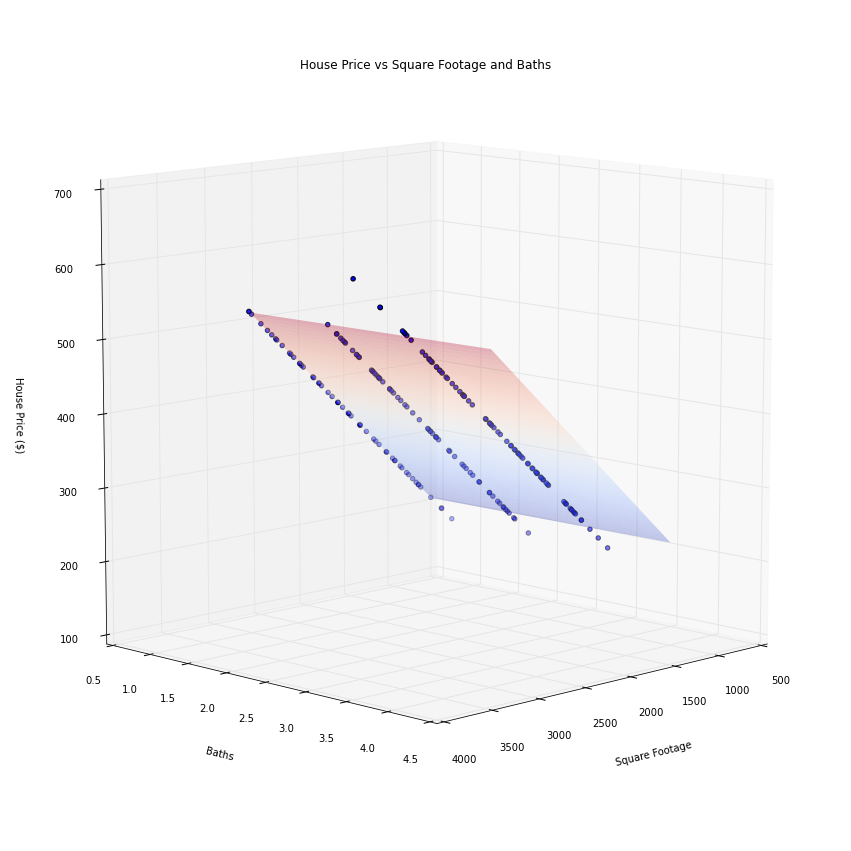

In [12]:
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(1, 1, 1, projection='3d')

A=50
X1 = np.linspace(min_sf, max_sf, A)
X2 = np.linspace(min_bath, max_bath, A)
X1, X2 = np.meshgrid(X1, X2)

Z=[]
for i in range(A):
    for j in range(A):
        Z.append(calc_house_price(theta0, theta1, theta2, X1[i][j], X2[i][j]))

Z = np.array(Z)
Z = Z.reshape(A, A)

ax.elev=10.0
ax.azim=45.0
ax.set_title("House Price vs Square Footage and Baths")
ax.set_xlabel("Square Footage")
ax.set_ylabel("Baths")
ax.set_zlabel("House Price ($)")
surf = ax.plot_surface(X1, X2, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=True, alpha=0.3)
ax.scatter(df.sqft, df.baths, df.price)

---
##Use the sklearn pre-processor
---

In [14]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True).fit(df[['sqft', 'baths']])
x_scaled =  scaler.transform(df[['sqft', 'baths']])

---
##Multivariate Linear Regression - SGD
---

In [28]:
#set the hyper-parameters of the model
clf = SGDRegressor(loss='squared_loss', eta0=0.001, fit_intercept=True, \
                   n_iter=20000, shuffle=True, verbose=False)

#for using scikit learn you always need to get the input arrays into the correct 'shape'
#x1 = x_scaled.reshape(m,1)

#fit the model
clf.fit(x_scaled, df['price'])
y_true = df['price']
y_hat = clf.predict(x_scaled)
print "MSE = ",mean_squared_error(y_true, y_hat)
print "Thetas: ", clf.coef_
print "Intercept:", clf.intercept_

MSE =  9.18821809423e-05
Thetas:  [ 95.68790107   0.53236731]
Intercept: [ 374.12943344]


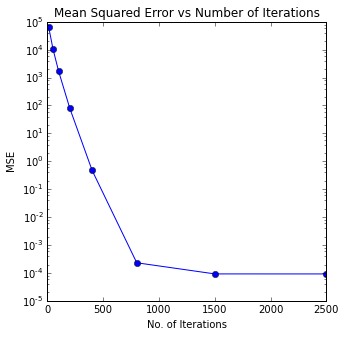

In [17]:
mse =[]
iters_list = [10, 50, 100, 200, 400, 800, 1500, 2500]
for iters in iters_list:
    clf = SGDRegressor(loss='squared_loss', eta0=0.001, fit_intercept=True, \
                       n_iter=iters, shuffle=True, verbose=False)
    clf.fit(x_scaled, df['price'])
    y_true = df['price']
    y_pred = clf.predict(x_scaled)
    mse.append(mean_squared_error(y_true, y_pred))
    
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(iters_list, mse, marker='o', color='b')
ax.set_title("Mean Squared Error vs Number of Iterations")
ax.set_xlabel("No. of Iterations")
ax.set_ylabel("MSE")
#ax.set_xscale("Log")
ax.set_yscale("Log")
#ax.set_xlim(-1, iters_list[-1])
#ax.set_ylim(0, 2e6)

---
##Make a prediction on a 2495 sqft house with 2 bathrooms
---

In [22]:
x_new = [2495.0, 2]
x_new_scaled = scaler.transform(x_new)
print "{:5.2f}".format(clf.predict(x_new_scaled))

450.55


---
#Use the normal equations
##Compare the values for the MSE, and model parameters with those obtained using SGD
---

In [27]:
#set the hyper-parameters of the model
clfLR = linear_model.LinearRegression(fit_intercept=True)

#for using scikit learn you always need to get the input arrays into the correct 'shape'
#fit the model
clfLR.fit(x_scaled, df['price'])

y_true = df['price']
y_pred = clf.predict(x_scaled)
print "MSE = ", mean_squared_error(y_true, y_pred)

print "Thetas: ", clfLR.coef_
print "Intercept:", clfLR.intercept_

MSE =  1.67617165141e-27
Thetas:  [ 95.69750651   0.53179972]
Intercept: 374.12943295


---
##Make a prediction using the model obtained from the Normal Equations
---

In [24]:
x_new = [2495.0, 2]
x_new_scaled = scaler.transform(x_new)
print "{:5.2f}".format(clfLR.predict(x_new_scaled))

450.55
